In [1]:
import numpy as np
import torch as th
import os
%load_ext autoreload
%autoreload 2
from PIL import Image 
from IPython.display import clear_output
from matplotlib.pyplot import imshow 
import matplotlib.pyplot as plt
import PIL
import torch

from itertools import islice
from torchvision.transforms.functional import to_tensor

import pandas as pd
from torchvision import transforms
from itertools import product
%matplotlib inline

# Add path to project 

In [2]:
import sys
sys.path
sys.path.append('/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/')

In [3]:
from util_files.rendering.cairo  import render,render_with_skeleton
from util_files.data.graphics_primitives import PT_LINE,  PT_CBEZIER, PT_QBEZIER
import  util_files.loss_functions.supervised  as supervised_loss 
from util_files.optimization.optimizer.scheduled_optimizer import ScheduledOptimizer
import util_files.dataloading as dataloading
from vectorization import load_model
from util_files.patchify import patchify
from util_files.geometric import liang_barsky_screen

/home/vage/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Parameters

In [4]:
device = torch.device('cuda:{}'.format(0))
prefetch_data = True
batches_completed_in_epoch=0
epoch_size = 20000
curve_count = 10
model_type = "model"

In [5]:
import sys; sys.argv=['']; del sys
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--output_dir', type=str, default="/home/vage/Downloads/testing_line/", help='dir to folder for output')
    parser.add_argument('--diff_render_it', type=int, default=90, help='iteration count')
    parser.add_argument('--init_random', action='store_true', default=False, dest='init_random',
                        help='init model with random [default: False].')
    parser.add_argument('--rendering_type', type=str, default='hard', help='hard -oleg,simple Alexey')
    parser.add_argument('--data_dir', type=str, default="/home/vage/Downloads/abc/", help='dir to folder for input')
    parser.add_argument('--image_name', type=str, default="00050000_99fd5beca7714bc586260b6a_step_000.png",
                        help='Name of image.If None will perform to all images in '
                             'folder.[default: None]')
    parser.add_argument('--overlap', type=int, default=0, help='overlap in pixel')
    parser.add_argument('--model_output_count', type=int, default=10, help='max_model_output')
    
    return parser.parse_args()

In [6]:
options = parse_args()

# Read image/dataset

In [7]:
def preprocess_image(image):
    patch_height, patch_width = image.shape[1:3]
    image = torch.as_tensor(image).type(torch.float32).reshape(-1, patch_height, patch_width) / 255
    image = 1 - image  # 0 -- background
    mask = (image > 0).type(torch.float32)
    _xs = np.arange(1, patch_width + 1, dtype=np.float32)[None].repeat(patch_height, 0) / patch_width
    _ys = np.arange(1, patch_height + 1, dtype=np.float32)[..., None].repeat(patch_width, 1) / patch_height
    _xs = torch.from_numpy(_xs)[None]
    _ys = torch.from_numpy(_ys)[None]
    return torch.stack([image, _xs * mask, _ys * mask], dim=1)

In [8]:
def read_data(options, image_type = 'RGB'):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset = []
    if options.image_name is None:
        image_names = os.listdir(options.data_dir)
        print(image_names)
        for image_name in image_names:
            if (image_name[-4:] != 'jpeg' and image_name[-3:] != 'png' and image_name[-3:] != 'jpg') or image_name[0]=='.':
                print(image_name[-4:])
                continue
            
            img = train_transform(Image.open(options.data_dir + image_name).convert(image_type))
            print(img.shape)
            img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                               img.shape[2] + (32 - img.shape[2] % 32))
            img_t[:, :img.shape[1], :img.shape[2]] = img
            dataset.append(img_t)
        options.image_name = image_names
    else:
        img = train_transform(Image.open(options.data_dir + options.image_name).convert(image_type))
        print(img.shape)
        img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                           img.shape[2] + (32 - img.shape[2] % 32))
        img_t[:, :img.shape[1], :img.shape[2]] = img
        dataset.append(img_t)
        options.image_name = [options.image_name]

    return dataset

In [9]:
images = read_data(options,image_type='L')

torch.Size([1, 2220, 2652])


In [10]:
image = images[0]

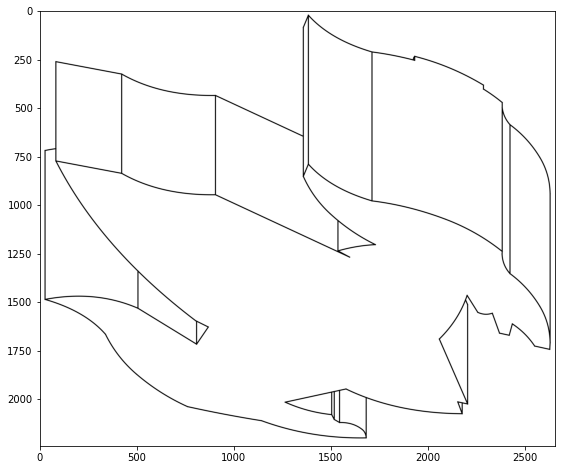

In [11]:
plt.figure(figsize=(12,8))
plt.imshow(image[0],'gray')

In [12]:
image

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

# Model loading 

In [13]:
# in json file you can chose model type and it's parameters as in examples in vectorization/models/specs/ folder

In [14]:
# chose json file 
model_json_param = '/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/vectorization/models/specs/resnet18_blocks3_bn_256__c2h__trans_heads4_feat256_blocks4_ffmaps512__h2o__out512.json'
#load/create model 
model = load_model(model_json_param).to(device)

In [15]:
def serialize(checkpoint):
    model_state_dict = checkpoint['model_state_dict']
    keys = []
    for k in model_state_dict:
        if 'hidden.transformer' in k:
            keys.append(k)

    for k in keys:
        new_key = 'hidden.decoder.transformer' + k[len('hidden.transformer'):]
        model_state_dict[new_key] = model_state_dict[k]
        del model_state_dict[k]
    return checkpoint
checkpoint = serialize(torch.load("/home/vage/Downloads/model_PseudoLap1.weights"))


model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Estimation of primitive 

In [16]:
def split_to_patches(rgb, patch_size, overlap=0):
    """Separates the input into square patches of specified size.

    :param rgb: input RGB image
    :type rgb: numpy.ndarray
    :param patch_size: size of patches in pixels (assuming
                        square patches)
    :type patch_size: int
    :param overlap: amount in pixels of how much the patches
                    can overlap with each other (useful for merging)
    :type overlap: int

    :returns patches, patches_offsets
    :rtype Tuple[numpy.ndarray, numpy.ndarray]
    """
    rgb = rgb.transpose(1, 2, 0)
    rgb_t = np.ones((rgb.shape[0] + 33, rgb.shape[1] + 33, rgb.shape[2])) * 255.
    rgb_t[:rgb.shape[0], :rgb.shape[1], :] = rgb
    rgb = rgb_t

    height, width, channels = rgb.shape

    assert patch_size > 0 and 0 <= overlap < patch_size
    patches = patchify(rgb,
                       patch_size=(patch_size, patch_size, channels),
                       step=patch_size - overlap)
    patches = patches.reshape((-1, patch_size, patch_size, channels))
    height_offsets = np.arange(0, height - patch_size, step=patch_size - overlap)
    width_offsets = np.arange(0, width - patch_size, step=patch_size - overlap)
    patches_offsets = np.array(list(
        product(height_offsets, width_offsets)
    ))
    return patches, patches_offsets, rgb

In [27]:
def save_svg(result_vector, size, name, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    if len(size)==2:
        size = (1,size[0],size[1])
    a ={PT_LINE:np.concatenate((result_vector[...,:-1], result_vector[...,-1][...,None]),axis=1)}
    rendered_image = render(a,(size[2],size[1]), data_representation='vahe',linecaps='round')
    
    return rendered_image
    
def assemble_vector_patches(patches_vector, patches_offsets):
    primitives = []
    i = 0
    for patch_vector, patch_offset in zip(patches_vector, patches_offsets):
        i += 1

        patch_vector[:, [0, 2]] += patch_offset[1]

        patch_vector[:, [1, 3]] += patch_offset[0]

        primitives.append(patch_vector)
    return np.array(primitives)

def tensor_vector_graph_numpy(y_pred_render, patches_offsets, options):

    nump = np.array(list(map(clip_to_box, y_pred_render.reshape(-1, 6).cpu().detach().numpy())))

    nump = assemble_vector_patches(np.array((nump.reshape(-1, options.model_output_count, 6))),
                                   np.array(patches_offsets))


    nump = nump.reshape(-1, 6)


    nump = nump[~np.isnan(nump).any(axis=1)]
 
    nump = nump[(nump[:, -2] > 0.3)]
    nump = nump[(nump[:, -1] > 0.5)]

    nump = nump[((nump[:, 0] - nump[:, 2]) ** 2 + (nump[:, 1] - nump[:, 3]) ** 2 >= 3)]

    return nump
def clip_to_box(y_pred, box_size=(64, 64)):
    width, height = box_size
    bbox = (0, 0, width, height)
    point1, point2 = y_pred[:2], y_pred[2:4]
    try:
        clipped_point1, clipped_point2, is_drawn = \
            liang_barsky_screen(point1, point2, bbox)
    except:
         return np.asarray([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

    if (clipped_point1 and clipped_point2):
        return np.asarray([clipped_point1, clipped_point2, y_pred[4:]]).ravel()
    else:
        return np.asarray([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

In [18]:
image_tensor = image.unsqueeze(0).to(device)
patches_rgb, patches_offsets, input_rgb = split_to_patches(image_tensor.cpu().numpy()[0] * 255, 64, options.overlap)

In [19]:
model.eval()
patches_vector = []
print('--- Preprocessing BEGIN')
patch_images = preprocess_image(patches_rgb)
print('--- Preprocessing END')

for it_batches in range(400, patch_images.shape[0] + 399, 400):
    it_start = it_batches - 400
    if it_batches > patch_images.shape[0]:
        it_batches = patch_images.shape[0]
    with torch.no_grad():
        if(it_start==0):
            patches_vector = model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()
        else:
            patches_vector = np.concatenate((patches_vector,model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()),axis=0)
patches_vector = torch.tensor(patches_vector) * 64

--- Preprocessing BEGIN
--- Preprocessing END


In [20]:
rendered_image = save_svg(tensor_vector_graph_numpy(torch.tensor(patches_vector), patches_offsets, options), image_tensor.shape[1:],
             options.image_name, options.output_dir + 'model_output/')

__main__:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/util_files/geometric.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  r = q / p
/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/util_files/geometric.py:39: RuntimeWarning: invalid value encountered in double_scalars
  r = q / p


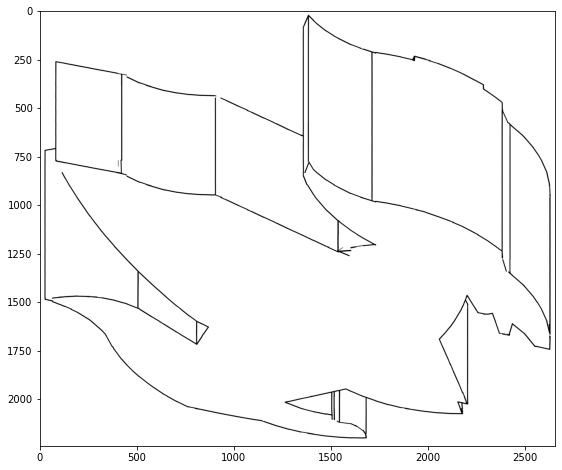

In [21]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image,"gray")

In [22]:
plt.imsave(options.output_dir + 'model_output/'+ options.image_name[0],rendered_image)

# Refinement 

In [23]:
from refinement.our_refinment.refinement_for_lines import render_optimization_hard
vector_after_opt = render_optimization_hard(patches_rgb, patches_vector, device, options, options.image_name[0])

/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/refinement/our_refinment/refinement_for_lines.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patches_vector = torch.tensor(patches_vector)
/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/refinement/our_refinment/utils/lines_refinement_functions.py:88: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427286/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
  0%|          | 0/90 [00:00<?, ?it/s]

init_random False


  0%|          | 0/90 [00:00<?, ?it/s]

0


  0%|          | 0/90 [00:00<?, ?it/s]

300


  0%|          | 0/90 [00:00<?, ?it/s]

600


  0%|          | 0/90 [00:00<?, ?it/s]

900


100%|██████████| 90/90 [00:15<00:00,  5.87it/s]

1200


In [28]:
rendered_image_opt= save_svg(tensor_vector_graph_numpy(vector_after_opt, patches_offsets, options), image.shape[1:],
         options.image_name[0], options.output_dir + 'diff_rendering_output/')

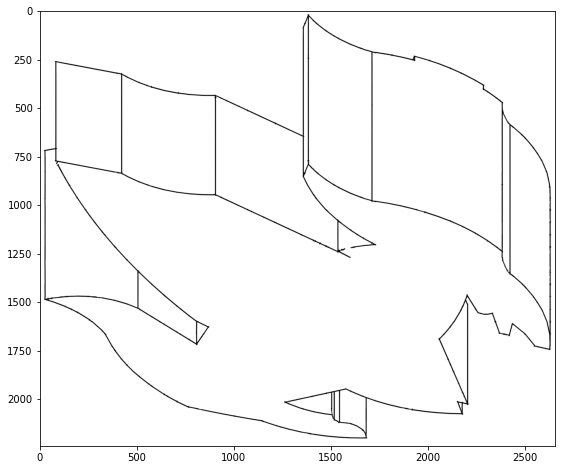

In [29]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image_opt,"gray")